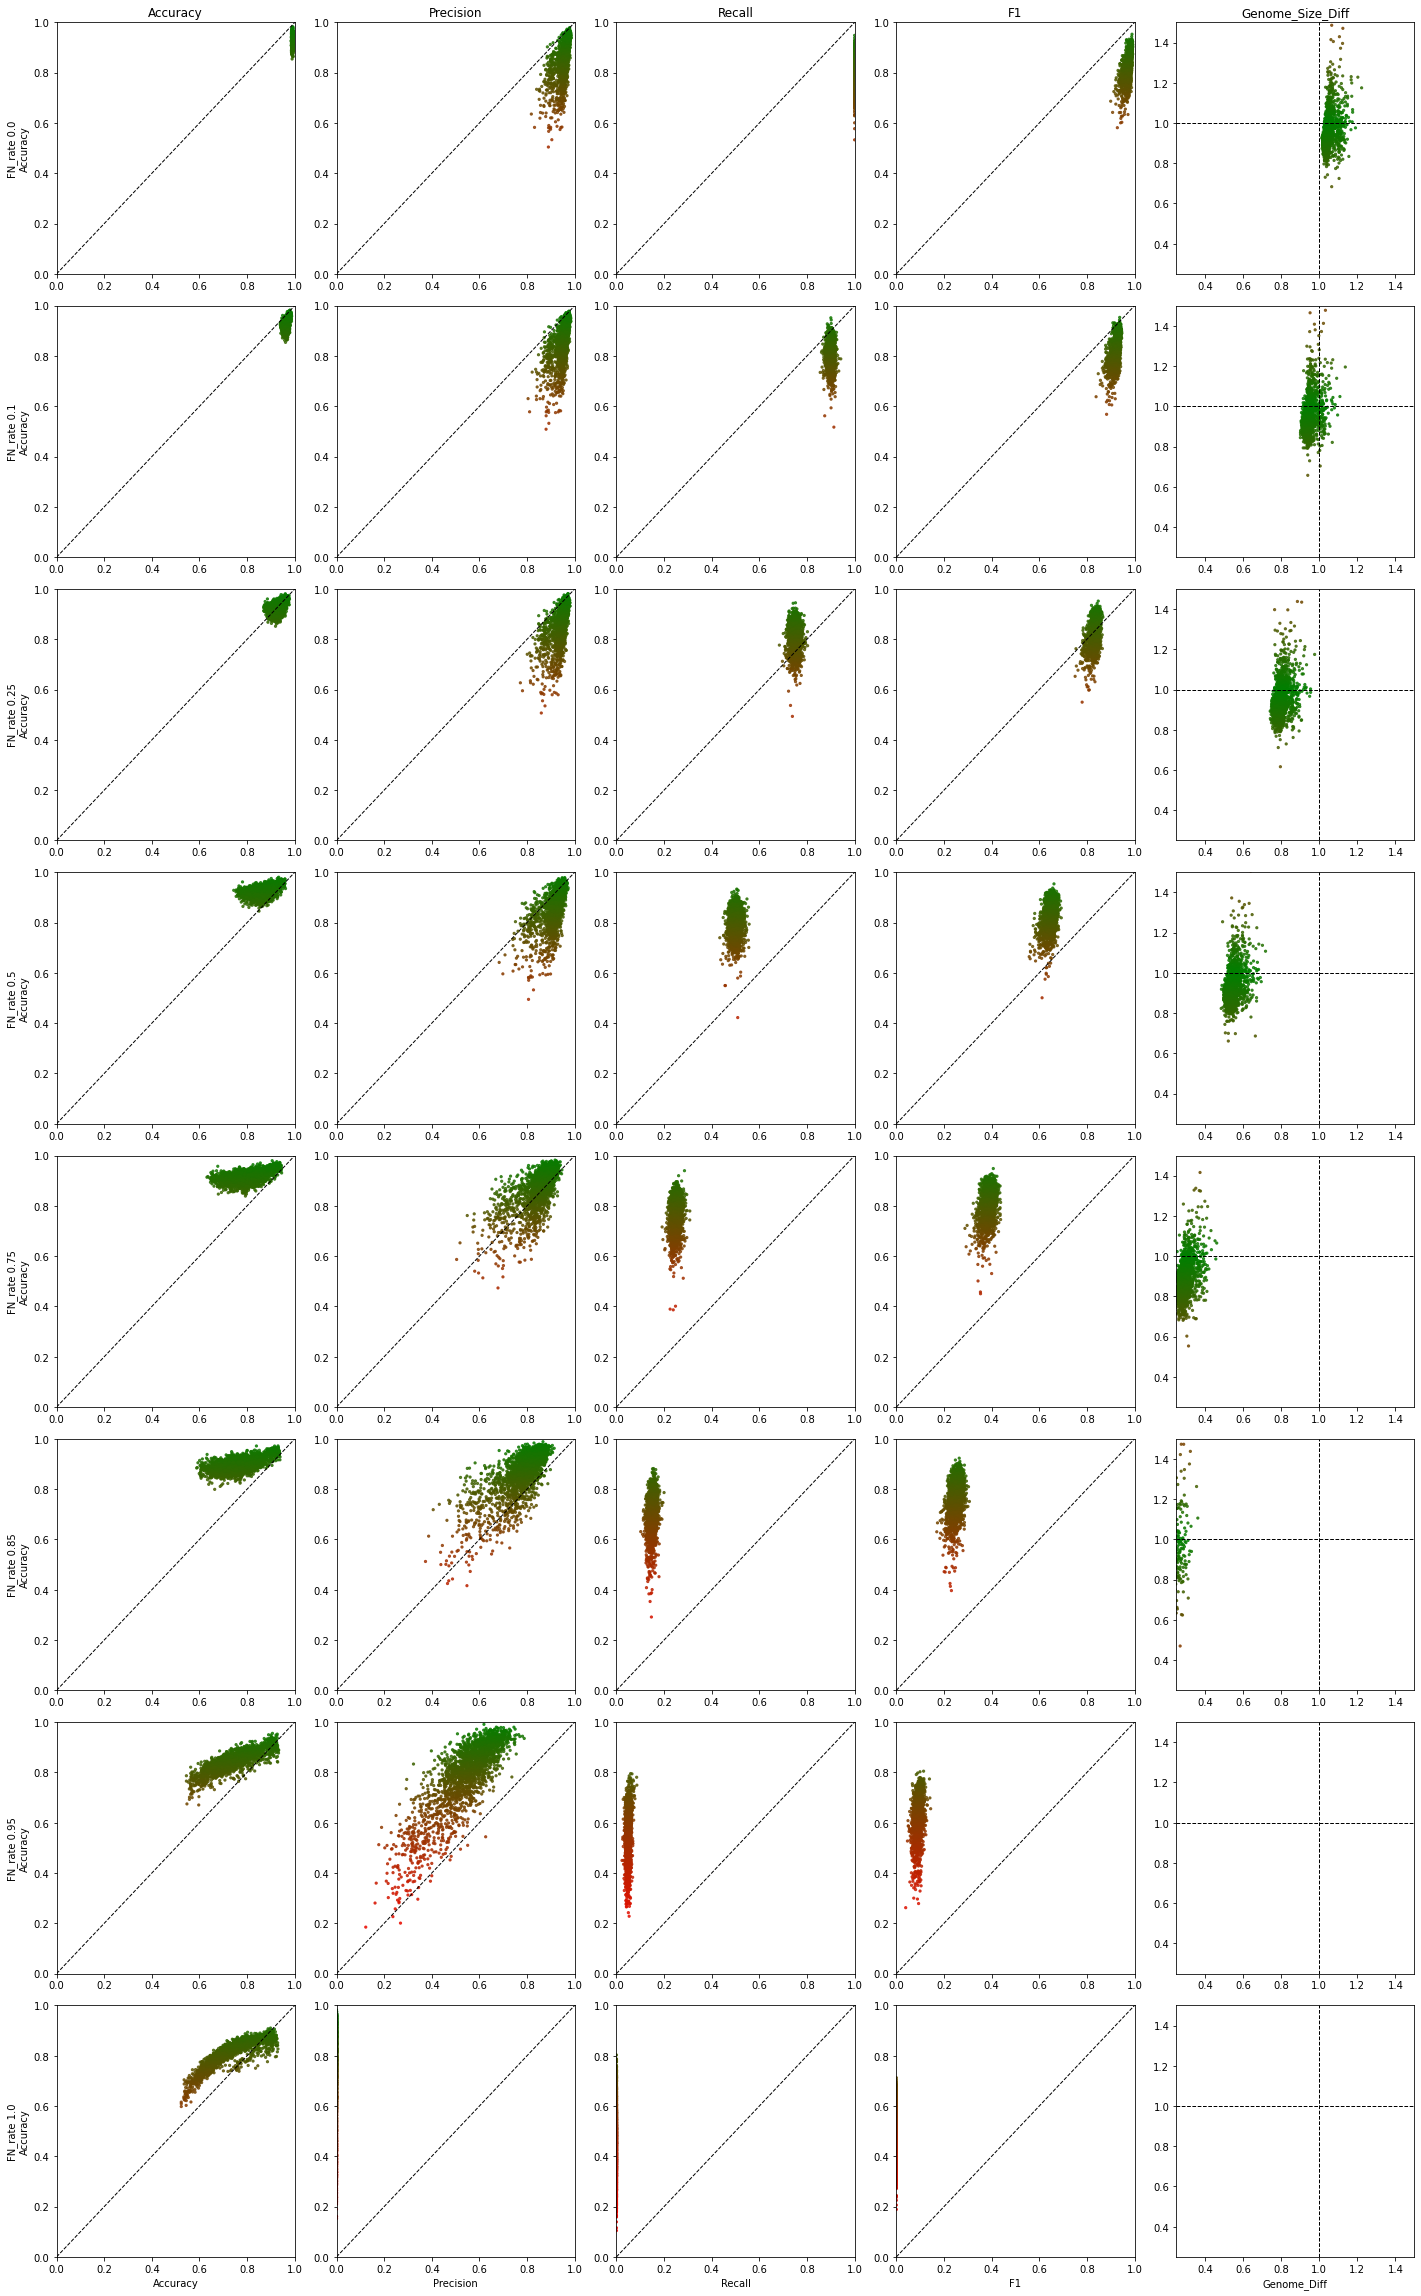

<Figure size 432x288 with 0 Axes>

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Load the CSV file.
df = pd.read_csv("per_sample_combined_metrics.csv")
df = pd.read_csv("per_sample_combined_metrics_FP0.01.csv")

# Filter to use only Pre-MLM rows.
df_pre = df[df["Stage"] == "Pre-MLM"]

# Get unique FN_rate values (assumed numeric) and sort them.
fn_rates = sorted(df_pre["FN_rate"].unique())
num_rows = len(fn_rates)

# Define the metric pairs: (noisy_metric, processed_metric).
metric_pairs = [
    ("noisy_accuracy", "accuracy"),
    ("noisy_precision", "precision"),
    ("noisy_recall", "recall"),
    ("noisy_f1", "f1"),
    ("noisy_genome_diff", "genome_size_diff")
]
num_cols = len(metric_pairs)

# Create colormaps:
# For metrics 1-4: red (0) to green (1).
cmap_rg = LinearSegmentedColormap.from_list("red_green", ["red", "green"])
# For genome_diff: use green for values close to 1.0, red for values far from 1.0.
cmap_gr = LinearSegmentedColormap.from_list("green_red", ["green", "red"])
max_diff = 1.0  # maximum absolute difference from 1.0 (since range is 0.25 to 4: max(1-0.25, 4-1)=3)

# Create a grid of subplots with 2 rows x 4 columns.
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows), sharex=False, sharey=False)

# Loop over FN_rate values (rows) and metric pairs (columns).
for i, fn in enumerate(fn_rates):
    subset = df_pre[df_pre["FN_rate"] == fn]
    for j, (noisy_col, proc_col) in enumerate(metric_pairs):
        ax = axes[i, j] if num_rows > 1 and num_cols > 1 else axes[max(i, j)]
        # For the first four metrics:
        if j < 4:
            # Color based on the processed metric (y value), which is assumed to be in [0,1].
            colors = [cmap_rg(val**1.5) for val in subset[proc_col]]
            ax.scatter(subset[noisy_col], subset[proc_col], color=colors, s=5, alpha=0.8)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.plot([0, 1], [0, 1], 'k--', lw=1)
        else:
            # For genome_diff: both x and y are in [0.25, 4]
            colors = [cmap_gr(abs(val - 1.0)/max_diff) for val in subset[proc_col]]
            ax.scatter(subset[noisy_col], subset[proc_col], color=colors, s=5, alpha=0.8)
            ax.set_xlim(0.25, 1.5)
            ax.set_ylim(0.25, 1.5)
            ax.axhline(y=1, color='k', linestyle='--', lw=1)
            ax.axvline(x=1, color='k', linestyle='--', lw=1)
        # Set labels: Only add axis labels on the bottom row and leftmost column.
        if i == num_rows - 1:
            ax.set_xlabel(noisy_col.replace("noisy_", "").title())
        if j == 0:
            ax.set_ylabel(f"FN_rate {fn}\n{proc_col.title()}")
        # Optionally add a title in the top row for each metric pair.
        if i == 0:
            ax.set_title(proc_col.title())
        
plt.tight_layout()
plt.show()
plt.savefig("metrics_scatter_by_FN_rate_2x4.png", dpi=300)

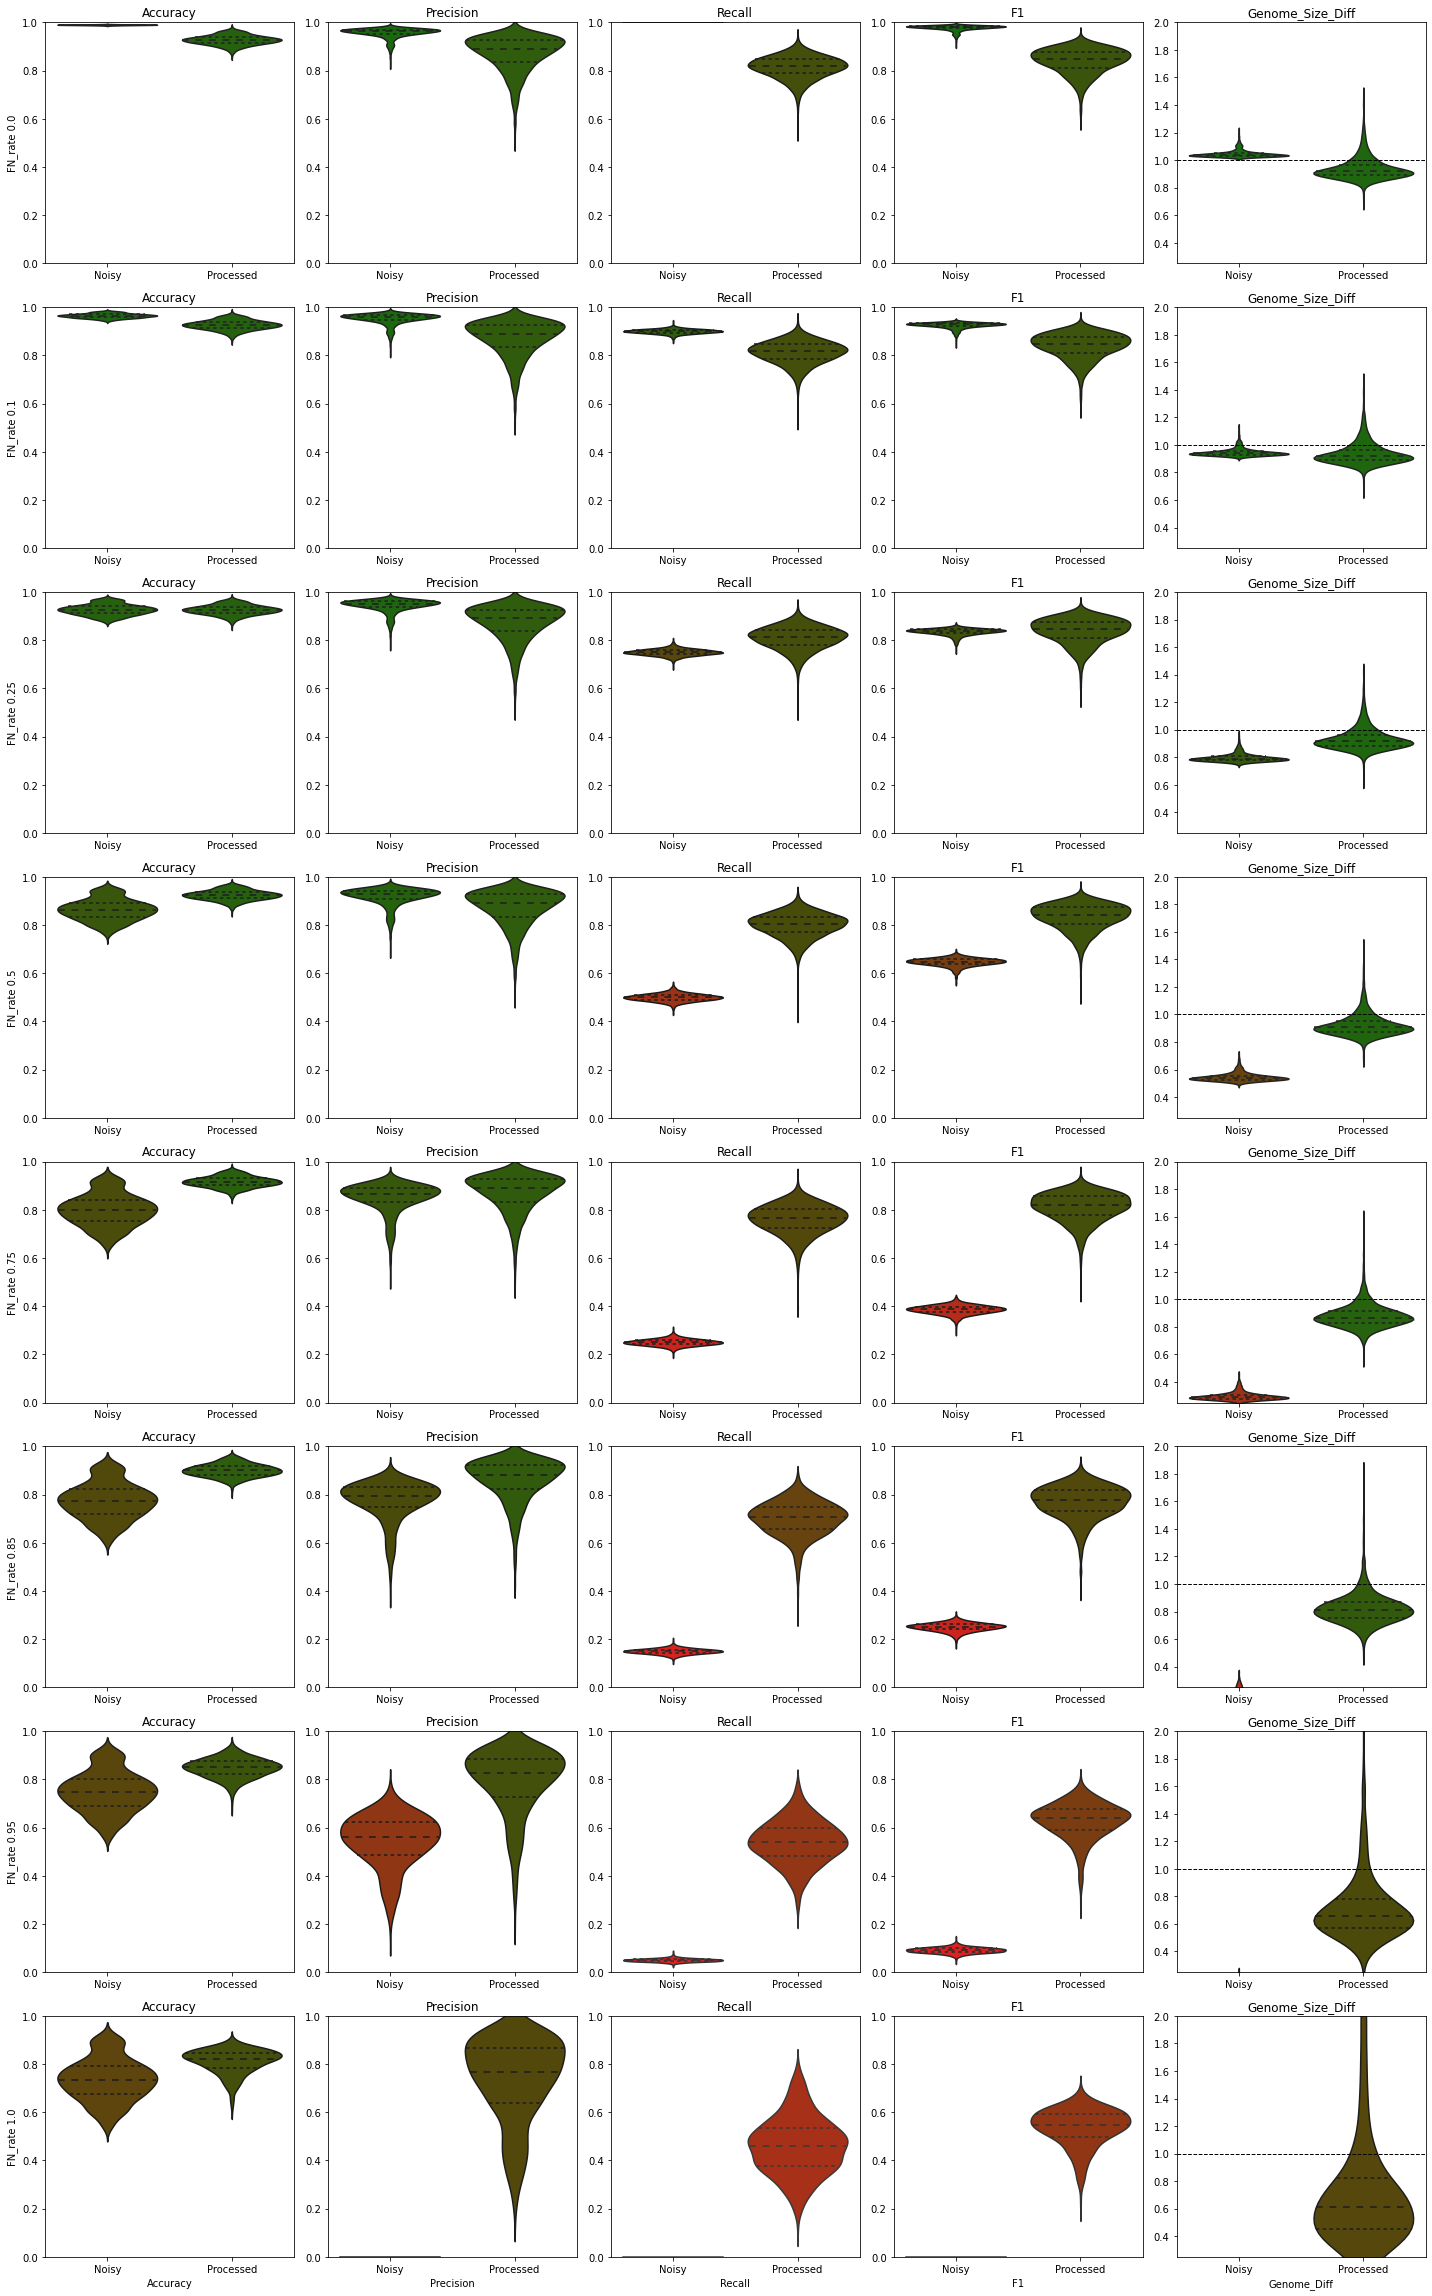

<Figure size 432x288 with 0 Axes>

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import math

# Load the CSV file.
df = pd.read_csv("per_sample_combined_metrics_FP0.01.csv")

# Filter to use only Pre-MLM rows.
df_pre = df[df["Stage"] == "Pre-MLM"].copy()

# Convert FN_rate column to numeric and drop NaN.
df_pre["FN_rate"] = pd.to_numeric(df_pre["FN_rate"], errors="coerce")
fn_rates = sorted(df_pre["FN_rate"].dropna().unique())
num_rows = len(fn_rates)

# Define metric pairs: (noisy_metric, processed_metric).
# Note: For genome_size_diff, we assume the desired range is [0.25,4].
metric_pairs = [
    ("noisy_accuracy", "accuracy"),
    ("noisy_precision", "precision"),
    ("noisy_recall", "recall"),
    ("noisy_f1", "f1"),
    ("noisy_genome_diff", "genome_size_diff")
]
num_cols = len(metric_pairs)

# Define colormaps.
# For metrics in [0,1]: use red-to-green (0 = red, 1 = green).
cmap_rg = LinearSegmentedColormap.from_list("red_green", ["red", "green"])
# For genome_size_diff: use green-to-red based on absolute deviation from 1.0.
cmap_gr = LinearSegmentedColormap.from_list("green_red", ["green", "red"])
max_diff = 1.0  # Because if range is [0.25,4], max(|1-0.25|,|4-1|)=3.

# Create a grid of subplots: one row per FN_rate, one column per metric pair.
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows), sharey=False)
# Ensure axes is a 2D array.
if num_rows == 1:
    axes = np.expand_dims(axes, axis=0)

# Loop over each FN_rate and each metric pair.
for i, fn in enumerate(fn_rates):
    subset = df_pre[df_pre["FN_rate"] == fn]
    for j, (noisy_col, proc_col) in enumerate(metric_pairs):
        ax = axes[i, j]
        # Create a new DataFrame with two groups: "Noisy" and "Processed".
        data = pd.DataFrame({
            "Group": ["Noisy"] * len(subset) + ["Processed"] * len(subset),
            "Value": pd.concat([subset[noisy_col], subset[proc_col]], ignore_index=True)
        })
        
        # Determine color for each group based on the median value.
        if proc_col != "genome_size_diff":
            # Values are in [0,1]. 0 maps to red, 1 to green.
            med_noisy = subset[noisy_col].median()
            med_proc = subset[proc_col].median()
            color_noisy = cmap_rg(med_noisy**1.75)
            color_proc = cmap_rg(med_proc**1.75)
            # Use these as fixed colors in the violin plot.
            palette = {"Noisy": color_noisy, "Processed": color_proc}
            ax.set_ylim(0, 1)
        else:
            # For genome_size_diff, values are in [0.25,4]. Color by deviation from 1.0.
            med_noisy = subset[noisy_col].median()
            med_proc = subset[proc_col].median()
            color_noisy = cmap_gr(abs(med_noisy - 1.0)/max_diff)
            color_proc = cmap_gr(abs(med_proc - 1.0)/max_diff)
            palette = {"Noisy": color_noisy, "Processed": color_proc}
            ax.set_ylim(0.25, 2)
            ax.axhline(y=1, color='k', linestyle='--', lw=1)

        # Create the violin plot.
        sns.violinplot(x="Group", y="Value", data=data, ax=ax, palette=palette, inner="quartile", width=0.8, scale="width", bw=0.25)
        
        # Set title and labels.
        ax.set_title(f"{proc_col.title()}")
        if i == num_rows - 1:
            ax.set_xlabel(noisy_col.replace("noisy_", "").title())
        else:
            ax.set_xlabel("")
        if j == 0:
            ax.set_ylabel(f"FN_rate {fn}")
        else:
            ax.set_ylabel("")

plt.tight_layout()
plt.show()
plt.savefig("violin_plots_by_FN_rate.png", dpi=300)

In [20]:
fn_rates

[np.float64(0.0),
 np.float64(0.1),
 np.float64(0.25),
 np.float64(0.5),
 np.float64(0.75),
 np.float64(0.85),
 np.float64(0.95),
 np.float64(1.0)]

In [19]:
fn_rates = sorted(df_pre["FN_rate"].unique())


In [34]:
!pip3 install --upgrade pandas

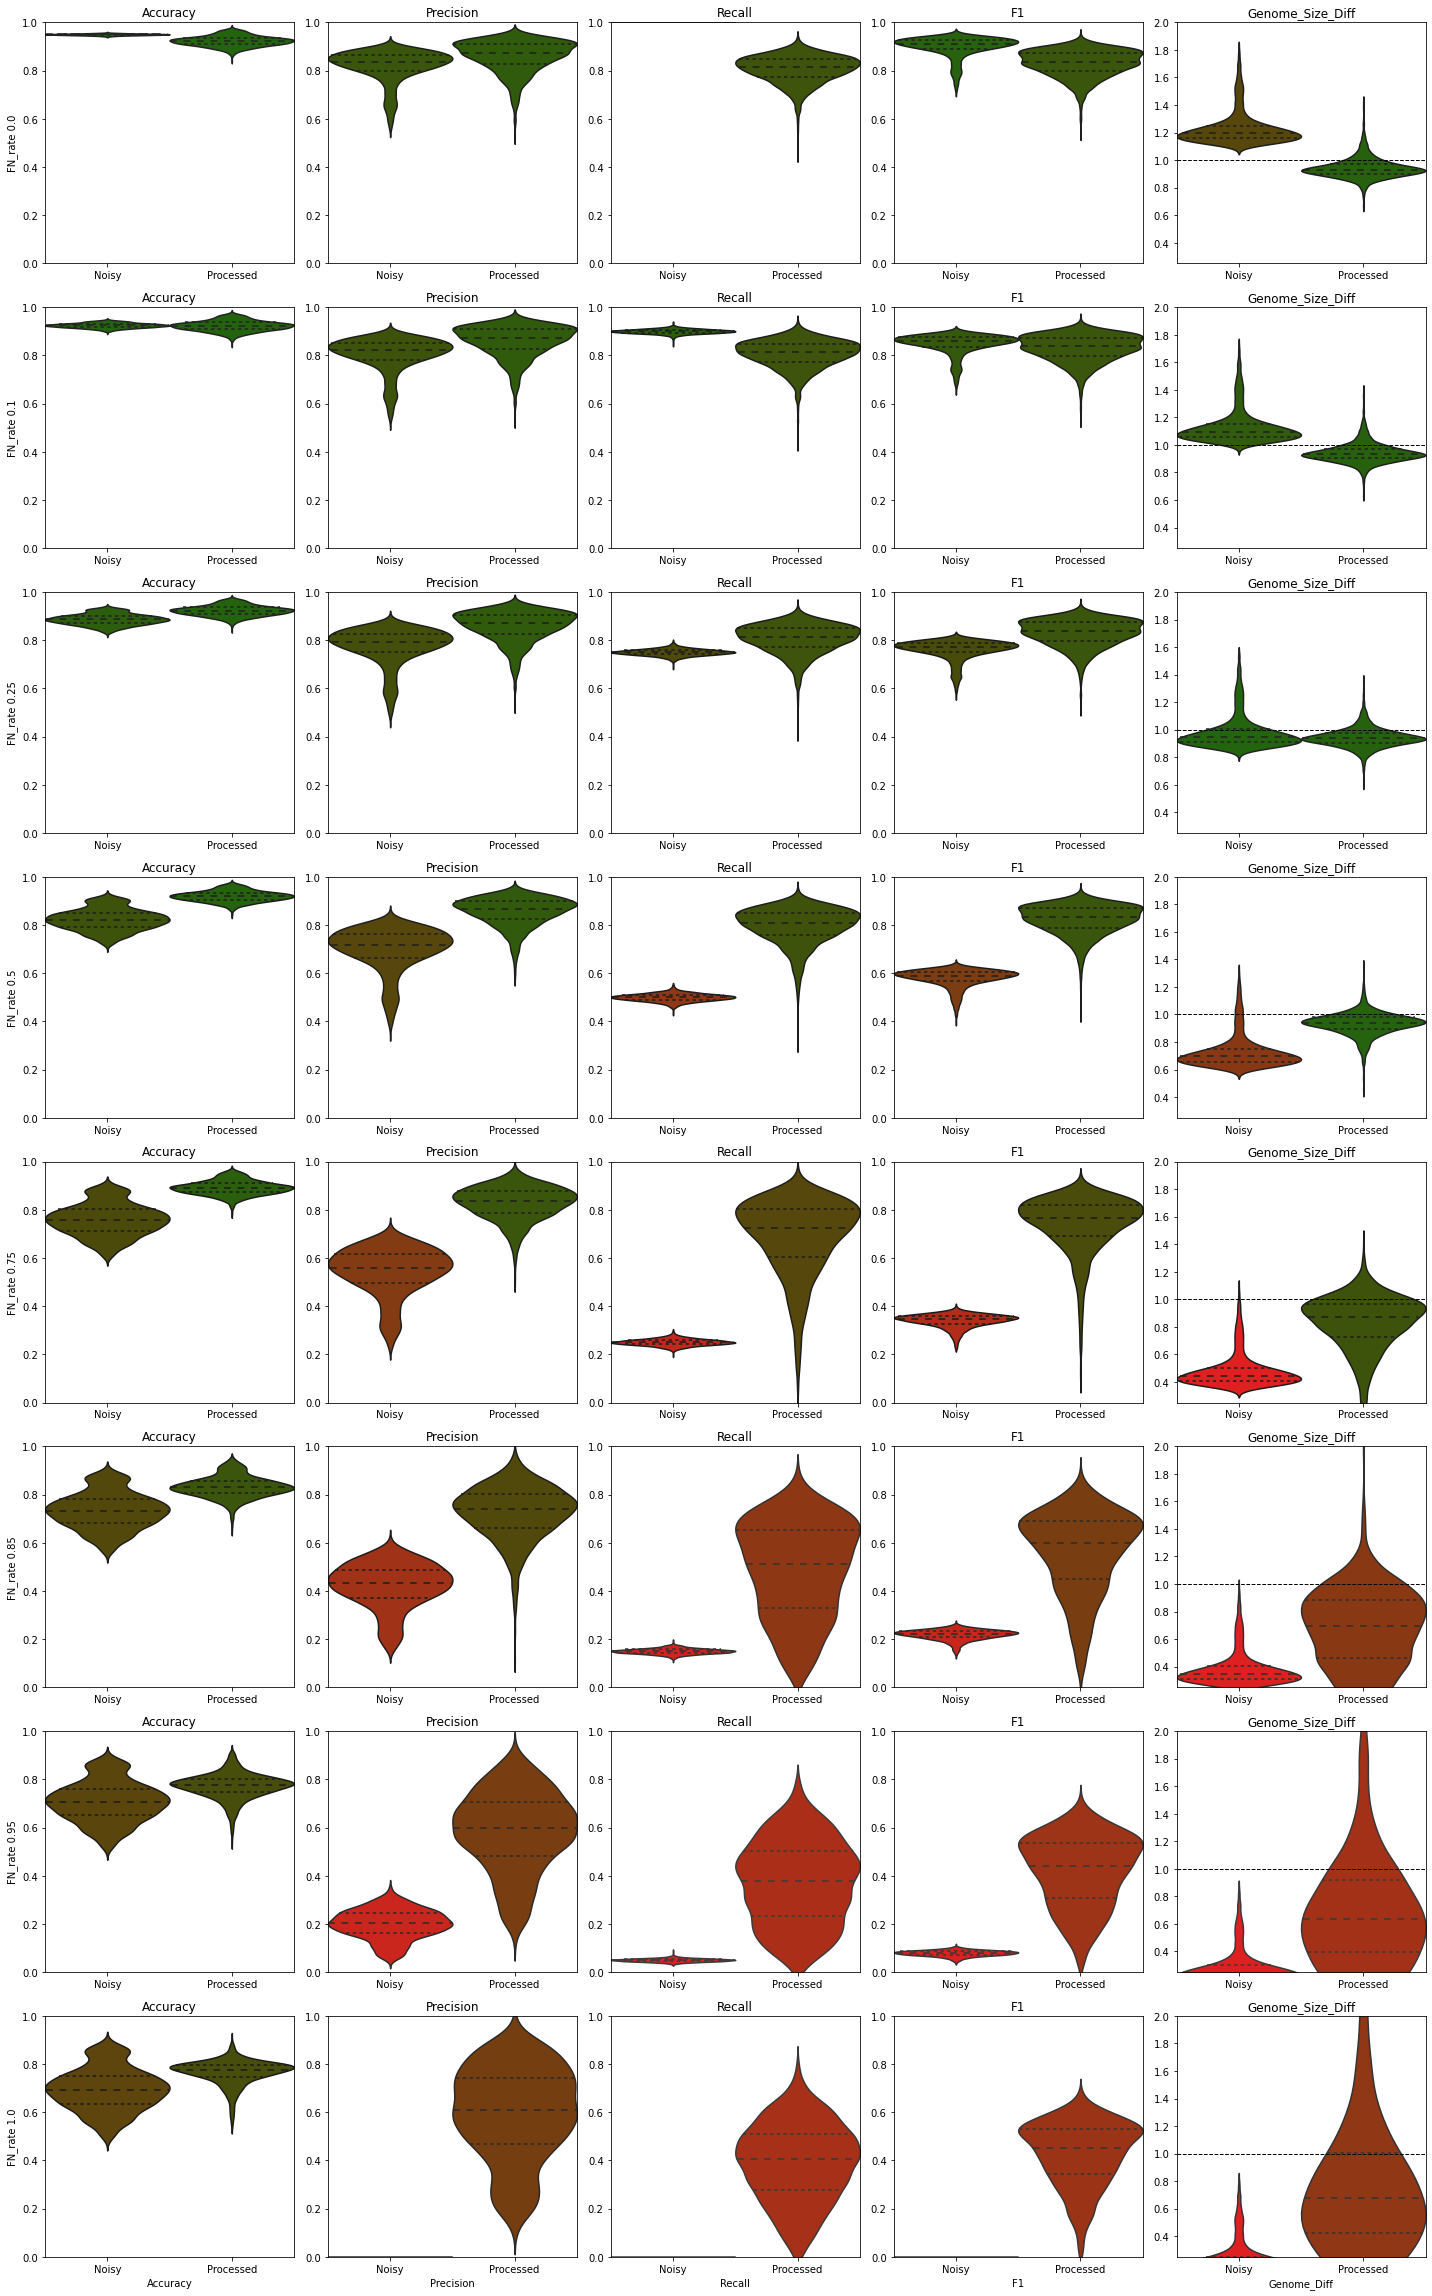

<Figure size 432x288 with 0 Axes>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import math

# ---------------------------
# 1. Load Data and Filter
# ---------------------------
df = pd.read_csv("per_sample_combined_metrics.csv")
df_pre = df[df["Stage"] == "Pre-MLM"].copy()

# Ensure FN_rate is numeric and drop NaNs.
df_pre["FN_rate"] = pd.to_numeric(df_pre["FN_rate"], errors="coerce")
fn_rates = sorted(df_pre["FN_rate"].dropna().unique())
num_rows = len(fn_rates)

# ---------------------------
# 2. Define Metric Pairs
# ---------------------------
# Each pair is (noisy_metric, processed_metric). For genome size difference, we'll use [0.25, 4].
metric_pairs = [
    ("noisy_accuracy", "accuracy"),
    ("noisy_precision", "precision"),
    ("noisy_recall", "recall"),
    ("noisy_f1", "f1"),
    ("noisy_genome_diff", "genome_size_diff")
]
num_cols = len(metric_pairs)

# ---------------------------
# 3. Define Colormaps and Parameters
# ---------------------------
# For metrics in [0,1]: use a red-green colormap (0 -> red, 1 -> green)
cmap_rg = LinearSegmentedColormap.from_list("red_green", ["red", "green"])
# For genome_size_diff: use a green-red colormap, based on absolute deviation from 1.
cmap_gr = LinearSegmentedColormap.from_list("green_red", ["green", "red"])
max_diff = 0.5  # because if range is [0.25, 4], max(|1-0.25|, |4-1|) = 3

# ---------------------------
# 4. Create a Grid of Violin Plots (One row per FN_rate, one column per metric pair)
# ---------------------------
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows), sharey=False)
if num_rows == 1:
    axes = np.expand_dims(axes, axis=0)

# Loop over each FN_rate and each metric pair.
for i, fn in enumerate(fn_rates):
    subset = df_pre[df_pre["FN_rate"] == fn]
    for j, (noisy_col, proc_col) in enumerate(metric_pairs):
        ax = axes[i, j]
        
        # Build a DataFrame with two groups: "Noisy" and "Processed"
        data = pd.DataFrame({
            "Group": ["Noisy"] * len(subset) + ["Processed"] * len(subset),
            "Value": pd.concat([subset[noisy_col], subset[proc_col]], ignore_index=True)
        })
        
        # For metrics [0,1]:
        if proc_col != "genome_size_diff":
            # Compute medians for each group.
            medians = data.groupby("Group")["Value"].median()
            # Map 0->red and 1->green.
            color_noisy = cmap_rg(medians["Noisy"]**1.5)
            color_processed = cmap_rg(medians["Processed"]**1.5)
            palette = {"Noisy": color_noisy, "Processed": color_processed}
            ax.set_ylim(0, 1)
        else:
            # For genome_size_diff: values are in [0.25, 4].
            medians = data.groupby("Group")["Value"].median()
            # For coloring, compute absolute deviation from 1 and normalize.
            color_noisy = cmap_gr(abs(medians["Noisy"] - 1.0) / max_diff)
            color_processed = cmap_gr(abs(medians["Processed"] - 1.0) / max_diff)
            palette = {"Noisy": color_noisy, "Processed": color_processed}
            ax.axhline(y=1, color='k', linestyle='--', lw=1)

            ax.set_ylim(0.25, 2)
        
        # Create the violin plot. (You can adjust width and scale if needed.)
        sns.violinplot(x="Group", y="Value", data=data, ax=ax, palette=palette,
                       inner="quartile", width=1.0, scale="width")
        
        # Set subplot title and labels.
        ax.set_title(proc_col.title())
        if i == num_rows - 1:
            ax.set_xlabel(noisy_col.replace("noisy_", "").title())
        else:
            ax.set_xlabel("")
        if j == 0:
            ax.set_ylabel(f"FN_rate {fn}")
        else:
            ax.set_ylabel("")

plt.tight_layout()
plt.show()
plt.savefig("violin_plots_by_FN_rate.png", dpi=300)

/var/folders/s5/5qyfbtgx7wdd9zg3q4zplgkc0000gn/T/ipykernel_94742/1609815473.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Group", y="Value", data=data, ax=axes[0, j],
/var/folders/s5/5qyfbtgx7wdd9zg3q4zplgkc0000gn/T/ipykernel_94742/1609815473.py:42: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x="Group", y="Value", data=data, ax=axes[0, j],
/var/folders/s5/5qyfbtgx7wdd9zg3q4zplgkc0000gn/T/ipykernel_94742/1609815473.py:42: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.25`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x="Group", y="Value", data=data, ax=axes[0, j],
/var/folder

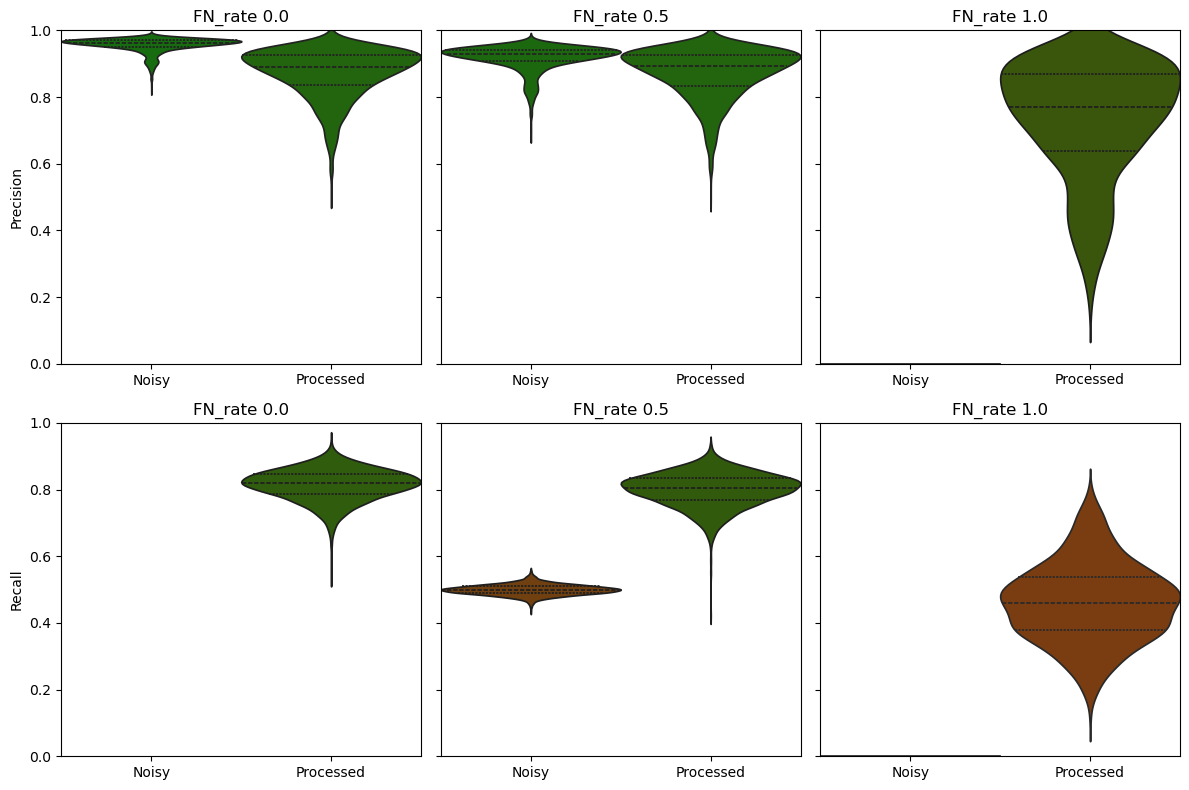

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Load the CSV file.
df = pd.read_csv("per_sample_combined_metrics_FP0.01.csv")

# Filter to use only Pre-MLM rows.
df_pre = df[df["Stage"] == "Pre-MLM"].copy()

# Convert FN_rate column to numeric and drop NaN.
df_pre["FN_rate"] = pd.to_numeric(df_pre["FN_rate"], errors="coerce")
# Keep only desired FN_rate values.
desired_fn = [0.0, 0.5, 1.0]#[0.0, 0.25, 0.5, 0.75, 0.95,1.0]
df_pre = df_pre[df_pre["FN_rate"].isin(desired_fn)]
fn_rates = sorted(df_pre["FN_rate"].unique())
num_cols = len(fn_rates)  # Should be 5.
num_rows = 2  # Top row for precision, bottom row for recall.

# Define a red-to-green colormap (0 = red, 1 = green).
cmap_rg = LinearSegmentedColormap.from_list("red_green", ["red", "green"])

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows), sharey=True)


# Top row: Precision.
for j, fn in enumerate(fn_rates):
    subset = df_pre[df_pre["FN_rate"] == fn]
    data = pd.DataFrame({
        "Group": ["Noisy"] * len(subset) + ["Processed"] * len(subset),
        "Value": pd.concat([subset["noisy_precision"], subset["precision"]], ignore_index=True)
    })
    # Determine colors from the group medians.
    med_noisy = subset["noisy_precision"].median()
    med_proc = subset["precision"].median()
    color_noisy = cmap_rg(med_noisy)
    color_proc = cmap_rg(med_proc)
    palette = {"Noisy": color_noisy, "Processed": color_proc}
    
    sns.violinplot(x="Group", y="Value", data=data, ax=axes[0, j],
                   palette=palette, inner="quartile", width=1.0, scale="width", bw=0.25)
    axes[0, j].set_ylim(0, 1)
    axes[0, j].set_title(f"FN_rate {fn}")
    axes[0, j].set_xlabel("")
    if j == 0:
        axes[0, j].set_ylabel("Precision")
    else:
        axes[0, j].set_ylabel("")

# Bottom row: Recall.
for j, fn in enumerate(fn_rates):
    subset = df_pre[df_pre["FN_rate"] == fn]
    data = pd.DataFrame({
        "Group": ["Noisy"] * len(subset) + ["Processed"] * len(subset),
        "Value": pd.concat([subset["noisy_recall"], subset["recall"]], ignore_index=True)
    })
    med_noisy = subset["noisy_recall"].median()
    med_proc = subset["recall"].median()
    color_noisy = cmap_rg(med_noisy)
    color_proc = cmap_rg(med_proc)
    palette = {"Noisy": color_noisy, "Processed": color_proc}
    
    sns.violinplot(x="Group", y="Value", data=data, ax=axes[1, j],
                   palette=palette, inner="quartile", width=1.0, scale="width", bw=0.25)
    axes[1, j].set_ylim(0, 1)
    axes[1, j].set_title(f"FN_rate {fn}")
    axes[1, j].set_xlabel("")
    if j == 0:
        axes[1, j].set_ylabel("Recall")
    else:
        axes[1, j].set_ylabel("")

plt.tight_layout()
#plt.savefig("violin_precision_recall_by_FN_rate.png", dpi=300)
plt.tight_layout()

plt.savefig("SetTransformer_FP001.pdf", bbox_inches="tight")

plt.show()
